In [115]:
pip install alpha_vantage

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
import time
import yfinance as yf
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
from keras.optimizers import Adam
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import load_model
import os
from functools import partial
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import qmc
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import shap
from alpha_vantage.timeseries import TimeSeries
from sklearn.linear_model import Lasso
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
import itertools
from tensorflow.keras.constraints import Constraint
from datetime import datetime
from tensorflow.keras.layers import Lambda

### Do not run the below cell if using local device

In [117]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NNcode/
directory = '/content/drive/MyDrive/NNcode'
# or cd /Users/xuyunpeng/Documents/Time-consistentPlanning/cleanup_code/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NNcode


In [192]:
import importlib
import functions
importlib.reload(functions)
from functions import *
print_version()

version 16.4


In [118]:
random.seed(10)

## Macro parameter setup

Note:

All monetary units are in per 1,000,000 USD, e.g., initial_capital = 1 means the initial capital value allowed to be allocated to assets and dividends is 1,000,000 USD.

In [198]:
T = 3
num_processes = 4
start_date = "2012-01-01" # can change
end_date = "2023-01-01"
numTrain = 2**11
numSim = numTrain
initial_capital = 1

gamma = 0.6
rdr = 0.08 # annual risk discount rate
rdr_monthly = (1+rdr)**(1/12) -1
v = 1/(1+rdr_monthly)
stock_lo, stock_up = 0.00, 0.05
cbond_lo, cbond_up = 0.55, 0.85
div_up = 0.0060
div_lo = 0.0000
print('v =', v, ', T = ', T)

v = 0.993607101988294 , T =  3


## VARIMA model: Claim Data

Assume the company's whole life policy portfolio includes 0.1% of total counts of death resulted from all causes in the US, and this policy exsited in the market since 2012.

The death benefit is USD 1,000 for all policy.

Counts of death data is obtainable from [this link](https://data.un.org/Data.aspx?d=POP&f=tableCode:65;countryCode:840;areaCode=0#:~:text=United%20States%20of%20America%202019,tabulated%20by%20year%20of%20occurrence) from year 2000 to 2019, and provisional counts of death data is obtainable from [here](https://data.cdc.gov/NCHS/Monthly-Provisional-Counts-of-Deaths-by-Select-Cau/9dzk-mvmi/about_data)
from year 2020 to 2023.
The two datasets are combined to obtain the `CountOfDeath_2000-2023.csv`.

In [4]:
death_data = pd.read_csv('CountOfDeath_2000-2023.csv')
death_data['Date'] = pd.to_datetime(death_data['Date'])
death_data.set_index('Date', inplace=True)
death_data = death_data[start_date:end_date]

# First multiply by 0.001 to get the number of deaths.
# Each death costs 1,000 USD, so multiply by 1,000. But the units are in 1,000,000, so need to divide by 1,000,000.
death_data['Deaths'] *= 0.001*1000/1000000

print(death_data)
p = np.mean(death_data) * 1.2
print('premium rate at loading of 1.2 is ', p)

              Deaths
Date                
2012-01-01  0.225368
2012-02-01  0.208962
2012-03-01  0.221438
2012-04-01  0.208145
2012-05-01  0.207931
...              ...
2022-09-01  0.251639
2022-10-01  0.265706
2022-11-01  0.268815
2022-12-01  0.301278
2023-01-01  0.289362

[133 rows x 1 columns]
premium rate at loading of 1.2 is  0.29026947067669173


## VARIMA Model: Asset price data

As discussed in the work, we assume the insurer invests its capital into corporate bonds, government bonds, and stocks.

Here we picked `VYM` as a representative for stocks, `HYG` for corporate bonds, and `TIP` for government bonds.

In [5]:
portfolio = ['VYM', 'HYG', 'TIP']
API_KEY = "3VNUSSWK4AQPWMMD"
ts = TimeSeries(key=API_KEY, output_format="pandas")
data_frames = []
for stock in portfolio:
    stock_data, meta_data = ts.get_daily(symbol=stock, outputsize="full")
    stock_data = stock_data[['4. close']]
    stock_data.columns = [stock]
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data = stock_data.sort_index()
    stock_data = stock_data.loc[start_date:end_date]
    stock_data = stock_data.resample('MS').first()
    data_frames.append(stock_data)
    time.sleep(15)

In [6]:
S = pd.concat(data_frames, axis=1, join="inner")
S = S.apply(pd.to_numeric)
S = S.dropna()
ln_S = np.log(S)
d_ln_S = np.diff(ln_S, axis=0)

combined = pd.concat([S, death_data], axis=1, join="inner").dropna()
combined.columns = portfolio + ['claim']

ln_combined = np.log(combined)
ln_combined.to_csv("ln_x.csv")
print(ln_combined)

d_ln_combined = ln_combined.diff().dropna()
d_ln_combined.to_csv("d_ln_x.csv")
d_ln_L = d_ln_combined['claim']
print(d_ln_combined)

                 VYM       HYG       TIP     claim
2012-01-01  3.821661  4.496694  4.759178 -1.490021
2012-02-01  3.837946  4.504244  4.781558 -1.565603
2012-03-01  3.864302  4.519067  4.773900 -1.507613
2012-04-01  3.886705  4.503470  4.770006 -1.569520
2012-05-01  3.885268  4.508219  4.779460 -1.570549
...              ...       ...       ...       ...
2022-08-01  4.665607  4.355554  4.763284 -1.347886
2022-09-01  4.646600  4.308918  4.715100 -1.379760
2022-10-01  4.579647  4.276249  4.665795 -1.325365
2022-11-01  4.670771  4.298509  4.666924 -1.313732
2022-12-01  4.727830  4.325721  4.694737 -1.199722

[132 rows x 4 columns]
                 VYM       HYG       TIP     claim
2012-02-01  0.016285  0.007551  0.022380 -0.075582
2012-03-01  0.026356  0.014823 -0.007658  0.057990
2012-04-01  0.022403 -0.015598 -0.003893 -0.061908
2012-05-01 -0.001437  0.004749  0.009453 -0.001029
2012-06-01 -0.071961 -0.048421  0.016414 -0.044560
...              ...       ...       ...       ...
2022-08

## Fitting a VARIMA(2,1,0) model create training data and testing sample paths


### Fitting VARIMA

In [9]:
# d_ln_x_data = pd.read_csv('/content/drive/MyDrive/NNcode/d_ln_x.csv', index_col=0)
d_ln_x_data = pd.read_csv('d_ln_x.csv', index_col=0)
d_ln_x_data = d_ln_x_data.apply(pd.to_numeric)

Phi_metrics, mu, Sigma = lasso_VAR_centered(p=2, data=d_ln_x_data, alpha=0.0001)
Phi1 = Phi_metrics[0]
Phi2 = Phi_metrics[1]
mu = mu.flatten()
print(Phi1)
print(Phi2)
print(mu)
print(Sigma)

[[-0.13504928 -0.03654134 -0.         -0.        ]
 [-0.         -0.         -0.         -0.        ]
 [ 0.          0.          0.         -0.        ]
 [ 0.          0.          0.00355031 -0.15001366]]
[[-0.09287744 -0.          0.         -0.        ]
 [-0.         -0.          0.          0.06341193]
 [-0.         -0.         -0.         -0.        ]
 [ 0.02463542  0.03086653  0.00296244 -0.07634566]]
[ 0.00691733 -0.00130514 -0.00049192  0.00221602]
[[ 1.75445866e-03  7.66178737e-04  7.10705555e-05 -2.82671716e-04]
 [ 7.66178737e-04  5.48393664e-04  1.23455998e-04 -1.59745170e-04]
 [ 7.10705555e-05  1.23455998e-04  2.08271149e-04 -1.62369531e-05]
 [-2.82671716e-04 -1.59745170e-04 -1.62369531e-05  5.79354382e-03]]


### Quantization Grid

In [120]:
# directory = '/Users/xuyunpeng/Documents/Time-consistentPlanning/cleanup_code/'

file_path = '300_4_nopti'

df = pd.read_csv(file_path, sep='\s+', header=None)

weights = df.iloc[:, 0].values
quant_knots_std = df.iloc[:, 1:5].values

L = np.linalg.cholesky(Sigma)
quant_knots = quant_knots_std @ L.T

N, d = quant_knots.shape

quantize_grid = np.zeros((T+1, N, d))
quantize_grid[1:] = np.tile(quant_knots[None, :, :], (T, 1, 1))

l = weights

### Testing and Validation sample paths

In [199]:
numTest = numSim


# d ln(x_t) sample paths

d_ln_S1_0, d_ln_S1_minus1 = d_ln_x_data.iloc[-1,0], d_ln_x_data.iloc[-2,0]
d_ln_S2_0, d_ln_S2_minus1 = d_ln_x_data.iloc[-1,1], d_ln_x_data.iloc[-2,1]
d_ln_S3_0, d_ln_S3_minus1 = d_ln_x_data.iloc[-1,2], d_ln_x_data.iloc[-2,2]
d_ln_L_0, d_ln_L_minus1 = d_ln_x_data.iloc[-1,3], d_ln_x_data.iloc[-2,3]

current_x = np.array([d_ln_S1_0, d_ln_S2_0, d_ln_S3_0, d_ln_L_0])
last_x = np.array([d_ln_S1_minus1, d_ln_S2_minus1, d_ln_S3_minus1, d_ln_L_minus1])

noise_vali, d_ln_S1_vali, d_ln_S2_vali, d_ln_S3_vali, d_ln_L_vali = VARMA_sim1( current_x, last_x, Sigma, numSim, T, mu, Phi1, Phi2)
noise_test, d_ln_S1_test, d_ln_S2_test, d_ln_S3_test, d_ln_L_test = VARMA_sim1( current_x, last_x,  Sigma, numSim, T, mu, Phi1, Phi2)


# d ln(x_{t-1}) sample paths

d_ln_S1t_minus1_vali = np.zeros((numSim, T+1))
d_ln_S2t_minus1_vali = np.zeros((numSim, T+1))
d_ln_S3t_minus1_vali = np.zeros((numSim, T+1))
d_ln_Lt_minus1_vali  = np.zeros((numSim, T+1))

d_ln_S1t_minus1_vali[:, 0] = d_ln_S1_minus1
d_ln_S2t_minus1_vali[:, 0] = d_ln_S2_minus1
d_ln_S3t_minus1_vali[:, 0] = d_ln_S3_minus1
d_ln_Lt_minus1_vali[:, 0]  = d_ln_L_minus1

d_ln_S1t_minus1_vali[:, 1:] = d_ln_S1_vali[:, :T]
d_ln_S2t_minus1_vali[:, 1:] = d_ln_S2_vali[:, :T]
d_ln_S3t_minus1_vali[:, 1:] = d_ln_S3_vali[:, :T]
d_ln_Lt_minus1_vali[:, 1:]  = d_ln_L_vali[:, :T]

### Determining the upper and lower bound of $C$

In [200]:
ln_L_0 = ln_combined.iloc[3, -1]
ln_L_vali = ln_L_0 + np.cumsum(d_ln_L_vali[:, 1:T+1], axis=1)
L_vali = np.exp(ln_L_vali)

R1 = np.exp(d_ln_S1_vali[:, 1:T+1])
R2 = np.exp(d_ln_S2_vali[:, 1:T+1])
R3 = np.exp(d_ln_S3_vali[:, 1:T+1])

max_return = np.max(np.max(np.stack([R1, R2, R3]), axis=0), axis = 0)
min_return = np.min(np.min(np.stack([R1, R2, R3]), axis=0), axis = 0)

max_L = np.max(L_vali, axis=0)
min_L = np.min(L_vali, axis=0)

c_max, c_min = initial_capital, initial_capital
for t in range(T):
    c_max = (c_max + p - div_lo * c_max) * max_return[t] - min_L[t]
    c_min = (c_min + p - div_up * c_min) * min_return[t] - max_L[t]

print(c_max,c_min)

2.243629670961952 0.509352363196772


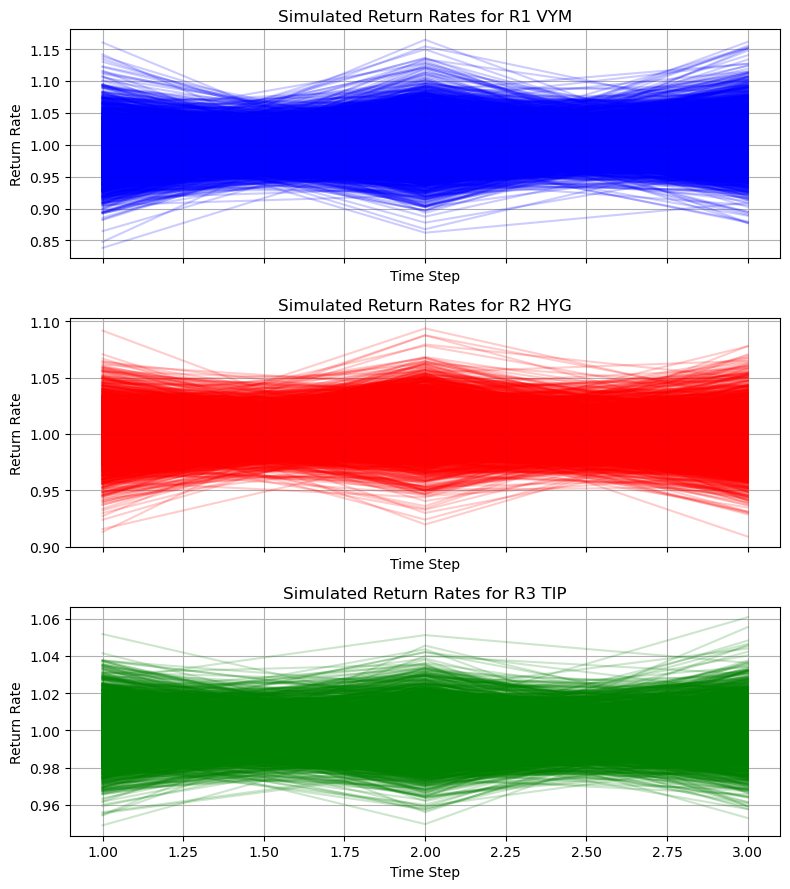

In [201]:
time_steps = range(1, T+1)
fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

for i in range(numSim):
    axs[0].plot(time_steps, R1[i, :], 'b-', alpha=0.2)
    axs[1].plot(time_steps, R2[i, :], 'r-', alpha=0.2)
    axs[2].plot(time_steps, R3[i, :], 'g-', alpha=0.2)

axs[0].set_title('Simulated Return Rates for R1 ' + portfolio[0])
axs[1].set_title('Simulated Return Rates for R2 ' + portfolio[1])
axs[2].set_title('Simulated Return Rates for R3 ' + portfolio[2])

for ax in axs:
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Return Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()

### Training Data

In [202]:
d_ln_S1t_train, d_ln_S1t_minus1_train, \
d_ln_S2t_train, d_ln_S2t_minus1_train, \
d_ln_S3t_train, d_ln_S3t_minus1_train, \
d_ln_Lt_train,  d_ln_Lt_minus1_train, \
ln_Lt_train, c_train = generate_training_data(
    d_ln_S1_vali, d_ln_S2_vali, d_ln_S3_vali, d_ln_L_vali,
    ln_L_vali, (c_min, c_max), numTrain, T
)

In [203]:
train_df = pd.DataFrame({
    'd_ln_S1t': d_ln_S1t_train,
    'd_ln_S1t_minus1': d_ln_S1t_minus1_train,
    'd_ln_S2t': d_ln_S2t_train,
    'd_ln_S2t_minus1': d_ln_S2t_minus1_train,
    'd_ln_S3t': d_ln_S3t_train,
    'd_ln_S3t_minus1': d_ln_S3t_minus1_train,
    'd_ln_Lt': d_ln_Lt_train,
    'd_ln_Lt_minus1': d_ln_Lt_minus1_train,
    'ln_Lt': ln_Lt_train,
    'c': c_train
})

print(train_df.describe())         # Min, max, mean, etc.

          d_ln_S1t  d_ln_S1t_minus1     d_ln_S2t  d_ln_S2t_minus1  \
count  2048.000000      2048.000000  2048.000000      2048.000000   
mean     -0.004645        -0.004645     0.001539         0.001539   
std       0.099173         0.099173     0.056112         0.056112   
min      -0.176365        -0.176232    -0.095544        -0.095595   
25%      -0.090525        -0.090425    -0.047058        -0.046982   
50%      -0.004701        -0.004671     0.001534         0.001551   
75%       0.081175         0.081110     0.050119         0.050086   
max       0.166964         0.166995     0.098621         0.098698   

          d_ln_S3t  d_ln_S3t_minus1      d_ln_Lt  d_ln_Lt_minus1        ln_Lt  \
count  2048.000000      2048.000000  2048.000000     2048.000000  2048.000000   
mean      0.003356         0.003356    -0.001873       -0.001873    -1.546442   
std       0.032150         0.032150     0.184075        0.184075     0.241519   
min      -0.052282        -0.052276    -0.320560      

## Training prep


In [204]:

class NonNegative(Constraint):
    def call(self, inputs):
        w_pos = tf.math.softplus(self.kernel)
        return tf.matmul(inputs, w_pos) + self.bias

def custom_loss(y_true, y_pred):
    value_loss = tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0]))
    control_loss = tf.reduce_mean(tf.square(y_true[:, 1:] - y_pred[:, 1:]))
    return value_loss + 1*control_loss

def activat_func(x):
    return -tf.math.softplus(-x)

## Main Training

In [205]:


def BuildAndTrainModel(
    d_ln_S1t_train, d_ln_S2t_train, d_ln_S3t_train, d_ln_Lt_train,
    d_ln_S1t_minus1_train, d_ln_S2t_minus1_train, d_ln_S3t_minus1_train, d_ln_Lt_minus1_train,
    ln_Lt_train, c1_train,
    quantizer, quantize_weights, v,
    validation_ratio = 0.1
    ):

    nn_dim, node_num, batch_num, epoch_num = 10, 40, 64, 500
    initializer_C      = tf.keras.initializers.RandomUniform(minval=0.01, maxval=0.1 , seed=0)
    initializer_others = tf.keras.initializers.RandomUniform(minval=-0.1 , maxval=0.1 , seed=0)

    X_raw = np.column_stack([
                            d_ln_S1t_train, d_ln_S2t_train, d_ln_S3t_train, d_ln_Lt_train,
                            d_ln_S1t_minus1_train, d_ln_S2t_minus1_train, d_ln_S3t_minus1_train, d_ln_Lt_minus1_train,
                            ln_Lt_train, c1_train
                            ])                      # shape: (N , 10)
    indices    = np.random.permutation(numTrain)          # <‑‑ shuffle ONCE
    cutoff     = int((1 - validation_ratio) * numTrain)
    idx_train, idx_valid = indices[:cutoff], indices[cutoff:]

    x_scaler   = StandardScaler().fit(X_raw[idx_train])
    X_scaled   = x_scaler.transform(X_raw)

    V_train  = np.zeros((T+1, cutoff))
    u_train  = np.zeros((T+1, cutoff, 3))
    tgt_train= np.zeros((T+1, cutoff, 4))
    V_valid  = np.zeros((T+1, numTrain-cutoff))
    u_valid  = np.zeros((T+1, numTrain-cutoff, 3))
    tgt_valid= np.zeros((T+1, numTrain-cutoff, 4))
    V_hat_θ  = np.empty(T+1, dtype=object)

    start = time.perf_counter()

    for t in range(T-1, 0, -1):
        tic = time.perf_counter()
        print(f"Time step {t}")

        # best_u12 = [(stock_lo + stock_up)/2, (cbond_lo + cbond_up)/2]

        for j in range(numTrain):
            if t < T-1:
                def j_v_t(u):
                    return V_t(
                                d_ln_S1t_train[j], d_ln_S2t_train[j], d_ln_S3t_train[j], d_ln_Lt_train[j],
                                d_ln_S1t_minus1_train[j], d_ln_S2t_minus1_train[j], d_ln_S3t_minus1_train[j], d_ln_Lt_minus1_train[j],
                                ln_Lt_train[j], c1_train[j], u,
                                mu, Phi1, Phi2, p,
                                V_hat_θ[t+1].get_weights(), x_scaler,
                                quantizer, t, l, gamma, v
                                )
                
            else:
                def j_v_t(u):
                    return V_T_minus1(
                                      d_ln_S1t_train[j], d_ln_S2t_train[j], d_ln_S3t_train[j], d_ln_Lt_train[j],
                                      d_ln_S1t_minus1_train[j], d_ln_S2t_minus1_train[j], d_ln_S3t_minus1_train[j], d_ln_Lt_minus1_train[j],
                                      ln_Lt_train[j], c1_train[j], u,
                                      mu, Phi1, Phi2, p,
                                      l, gamma, v, quantizer
                                      )

            u_star, jv_max, best_u12 = optimize_u_general(
                t=t, quantize_weights=quantize_weights, g=g, j_v_t=j_v_t,
                d_ln_S1t=d_ln_S1t_train[j], d_ln_S2t=d_ln_S2t_train[j],
                d_ln_S3t=d_ln_S3t_train[j], d_ln_Lt=d_ln_Lt_train[j],
                d_ln_S1t_minus1=d_ln_S1t_minus1_train[j],
                d_ln_S2t_minus1=d_ln_S2t_minus1_train[j],
                d_ln_S3t_minus1=d_ln_S3t_minus1_train[j],
                d_ln_Lt_minus1=d_ln_Lt_minus1_train[j],
                ln_Lt=ln_Lt_train[j], C_t=c1_train[j],
                mu=mu, Phi1=Phi1, Phi2=Phi2, p=p, quantizer=quantizer,
                stock_lo=stock_lo, stock_up=stock_up,
                cbond_lo=cbond_lo, cbond_up=cbond_up,
                div_lo=div_lo, div_up=div_up,
                best_u12=None
            )
            if j in idx_train:
                j2 = np.where(idx_train == j)[0][0]
                V_train[t,  j2]    = jv_max
                u_train[t,  j2, :] =  u_star
                tgt_train[t,j2,:]  = [jv_max, *u_star]
            else:
                j2 = np.where(idx_valid == j)[0][0]
                V_valid[t,  j2]    = jv_max
                u_valid[t,  j2, :] =  u_star
                tgt_valid[t,j2,:]  = [jv_max, *u_star]

        print(f"     all optimizations done: {round((time.perf_counter()-tic)/60,2)} min.")

        inp        = Input(shape=(nn_dim,))
        inp_other, inp_C = inp[:,:-1], inp[:,-1:]
        free       = Dense(node_num, 'tanh', kernel_initializer=initializer_others)(inp_other)
        for _ in range(3):
            free = Dense(node_num, 'tanh', kernel_initializer=initializer_others)(free)
        C_branch   = Dense(2, activat_func,
                           kernel_initializer=initializer_C,
                           kernel_constraint=NonNegative())(inp_C)
        merged     = Concatenate()([free, C_branch])
        hid        = Dense(node_num, activat_func,
                           kernel_initializer=initializer_C,
                           kernel_constraint=NonNegative())(merged)
        out        = Dense(4, kernel_initializer=initializer_C,
                           kernel_constraint=NonNegative())(hid)
        model      = Model(inp, out)
        model.compile(optimizer = Adam(1e-4), loss = custom_loss)

        Xtr = X_scaled[idx_train]
        tic_tr = time.perf_counter()
        ytr = tgt_train[t]
        model.fit(Xtr, ytr,
                  epochs=epoch_num, batch_size=batch_num,
                  verbose=0, shuffle=True)          # <‑‑ shuffle each epoch
        print(f"     Training time: {round((time.perf_counter()-tic_tr)/60,2)} min.")

        V_hat_θ[t] = model

        y_pred_tr   = model.predict(Xtr , verbose=0)
        mse_V_tr    = mean_squared_error(ytr[:,0], y_pred_tr[:,0])
        mse_all_tr  = mean_squared_error(ytr       , y_pred_tr)
        print(f"     Training MSE (V only): {mse_V_tr:.4g} | all: {mse_all_tr:.4g}")

        Xva         = X_scaled[idx_valid]
        yva         = tgt_valid[t]
        y_pred_va   = model.predict(Xva , verbose=0)
        mse_V_va    = mean_squared_error(yva[:,0], y_pred_va[:,0])
        mse_all_va  = mean_squared_error(yva     , y_pred_va)
        print(f"     Validation MSE (V only): {mse_V_va:.4g} | all: {mse_all_va:.4g}")
        # print(ytr)

    print(f"Duration: {round((time.perf_counter()-start)/60,2)} min total.")
    return V_hat_θ, x_scaler, V_train, u_train


To avoid approximating the control as a function of state variables, we surrogate the value function directly, and optimize it per sample path to obtain the optimal control for that sample path for a particular problem.

After realizing the value function barely reacts to the state variables other than $C$, gpt suggested a 2 head (terminal node) NN.

The NN has shared layers, one terminal node is for the value function, and one is for the optimal control. In the shared layers, the weights and biases are the same for value function node and control node.

This is different from the authors' approach, where the NN strcuture (no. of layers, nodes, etc.) are shared, but not the layers. The key weakness of the authors' approach on training value function is that when one state variable is dominating the value function, it is possible that the NN only 'learnt' the dominating state variable while completely ignoring the others.

The regression tasks are not conflicting with each other, as the training MSE did not change by much. the control head serves as the auxillary head that enforces the shared layers to 'see' the state variables other than $C$, which in our case are the prices. Hence, the NN is learnt not only the $C$, but all state variables that are related to the policy.



In [206]:

V_hat_theta, in_scaler, V_train, u_train\
= BuildAndTrainModel(d_ln_S1t_train, d_ln_S2t_train, d_ln_S3t_train, d_ln_Lt_train,
                    d_ln_S1t_minus1_train, d_ln_S2t_minus1_train, d_ln_S3t_minus1_train, d_ln_Lt_minus1_train,
                    ln_Lt_train, c_train,
                    quantize_grid, weights, v)

Time step 2
     all optimizations done: 0.03 min.
     Training time: 2.65 min.
     Training MSE (V only): 0.007567 | all: 0.005203
     Validation MSE (V only): 0.009744 | all: 0.005663
Time step 1


KeyboardInterrupt: 

## SHAP

`ExactExplainer` computes the shapley values for state variable $i$ for a specific $\boldsymbol{y}$.

Let $|\boldsymbol{y}|=M$ which $M=10$ in our case. $\Pi$ is the set of all possible permutations of indices for $1,2,...,M$, thus $|\Pi|=M!$.

Let $A_i^{(\pi)}$ be the subset of the $\pi$-th element of $\Pi$ comprised of the indices before $i$. This subset represents a specific 'context' to evaluate the 'marginal contribution' of state variable $i$.  

Let $\boldsymbol{y}_{[A_i^{(\pi)}]}$ be a subvector of that specific $\boldsymbol{y}$ with the indices in $A_i^{(\pi)}$.

Note, the state variables at indices that are not included in $A_i^{(\pi)}$ are set to be baseline values, and in `shap.Explainer`, it is set to be the (training) sample average of that state variable, i.e. $\frac{1}{N}\sum {}^{j}\boldsymbol{y}, N\leq n$.

The shapley value are computed as below:

$$
\phi_i(\mathring{V}^{ \hat \theta_t}, \boldsymbol{y}) = \frac{1}{M!} \sum_{\pi \in \Pi} \mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}\cup \{i\}]}) - \mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}]}).
$$

This is $\phi_i$ calculating the average marginal value of output of including state variable $i$ across all possible scenarios where $i$ is added to some subset of the other $M-1$ variables.

In $\mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}\cup \{i\}]}) - \mathring{V}^{ \hat \theta_t}(\boldsymbol{y}_{[A_i^{(\pi)}]})$, this difference represents how much variable $i$ changes the model output within that specific context $\pi$. By averaging this quantity over all $M!$ permutations of context, we effectively consider every possible subset of variables to which $i$ could be added, and how much it would impact the function's value in each context. This ensures that the final Shapley value $\phi_i$ is fair and context-aware, accounting for feature interactions and dependencies in a principled way.

For a specific ${}^{j}\boldsymbol{y}$, we can compute a ${}^{j}\phi_i$, and plotting the values we get the below plots.


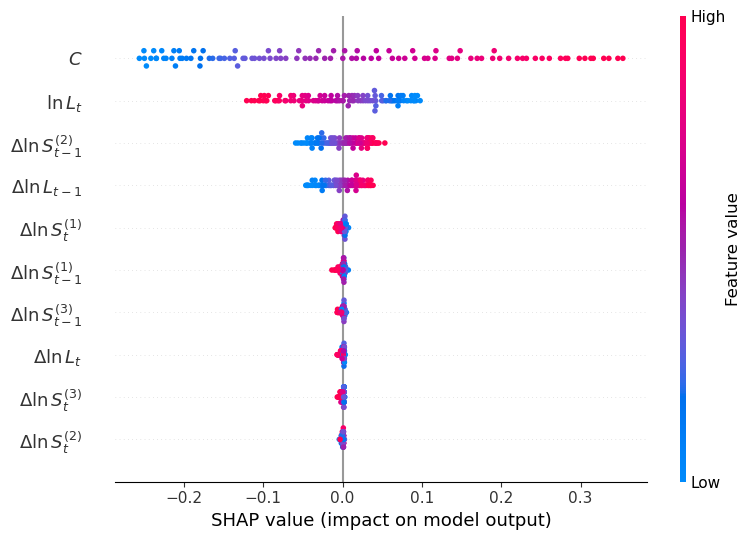

<class 'shap.explainers._exact.ExactExplainer'> , time step  1


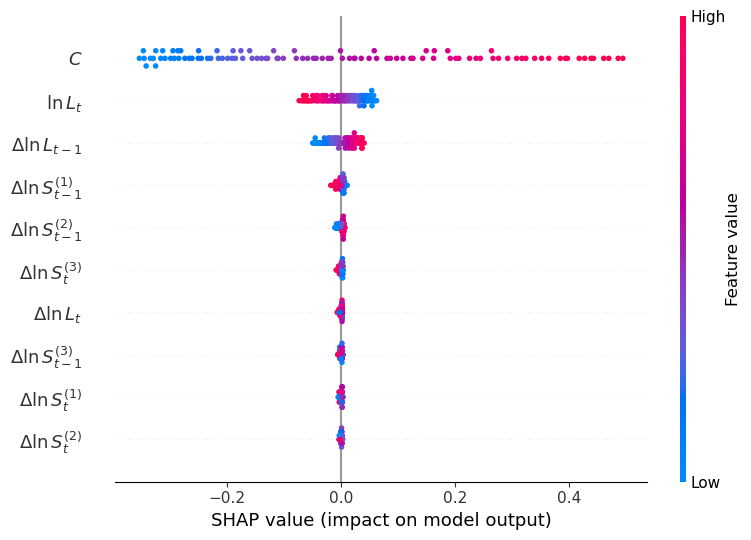

<class 'shap.explainers._exact.ExactExplainer'> , time step  2


In [194]:

input_train = np.concatenate((
                                d_ln_S1t_train.reshape(-1,1),
                                d_ln_S2t_train.reshape(-1,1),
                                d_ln_S3t_train.reshape(-1,1),
                                d_ln_Lt_train.reshape(-1,1),
                                d_ln_S1t_minus1_train.reshape(-1,1),
                                d_ln_S2t_minus1_train.reshape(-1,1),
                                d_ln_S3t_minus1_train.reshape(-1,1),
                                d_ln_Lt_minus1_train.reshape(-1,1),
                                ln_Lt_train.reshape(-1,1),
                                c_train.reshape(-1,1)
                                ), axis = 1)
input_data_scaled = in_scaler.transform(input_train)
state_variables = [
    '$\\Delta \\ln S^{(1)}_t$', '$\\Delta \\ln S^{(1)}_{t-1}$',
    '$\\Delta \\ln S^{(2)}_t$', '$\\Delta \\ln S^{(2)}_{t-1}$',
    '$\\Delta \\ln S^{(3)}_t$', '$\\Delta \\ln S^{(3)}_{t-1}$',
    '$\\Delta \\ln L_t$',  '$\\Delta \\ln L_{t-1}$',
    '$\\ln L_t$', '$C$',
]
input_df = pd.DataFrame(input_data_scaled[:100], columns=state_variables) # N=100

for s in range(T-1):
    t = s+1
    V_output_only = Lambda(lambda x: x[:, 0:1])(V_hat_theta[t].output)
    V_model = Model(inputs=V_hat_theta[t].input, outputs=V_output_only)
    explainer = shap.Explainer(V_model, input_df)
    shap_values = explainer(input_df)
    shap.summary_plot(shap_values.values, input_df)
    print(type(explainer), ', time step ', t)

should be reasonable to see S2 being more influential, because S1 and S3 have very narrow bounds, stock_lo and stock_up made a small interval for S1 to actually craete an impact.

#### Key Observations Over Time

- **Early Periods (e.g., $t = T-4$)**:
  - Features such as capital $C$, lagged asset return $\Delta \ln S^{(2)}_{t-1}$, and lagged liability return $\Delta \ln L_{t-1}$ dominate.
  - SHAP values have larger magnitudes, suggesting model sensitivity to state variables when there's more time to plan ahead. This is consistent with dynamic programming intuition: the earlier the stage, the more influence the state has on long-term value.

- **Mid Periods (e.g., $t = T-3, T-2$)**:
  - $C$, $\Delta \ln L_{t-1}$, and $\Delta \ln S^{(2)}_{t-1}$ remain important, though their SHAP value impact starts to decline.
  - More current variables like $\ln L_t$, $\Delta \ln S^{(3)}_t$ begin to gain relevance.

- **Final Period ($t = T-1$)**:
  - Influence becomes more **localized**, fewer features matter, and the magnitude of SHAP values drops sharply.
  - This is expected—at the last step, future utility doesn't propagate, so state variables at $t$ dominate.
  - Notably, the SHAP importance of $C$ drops as the model has less time to leverage capital for compounding returns.

---

#### Role of the VAR(2) Structure

The structure of the liability return equation explains several SHAP effects:

$$
\begin{aligned}
\Delta \ln L_t &= 0.00083
+ 0.00558 \cdot (\Delta \ln S^{(3)}_{t-1} + 0.00041)
- 0.16387 \cdot (\Delta \ln L_{t-1} - 0.00083) \\
&\quad + 0.03034 \cdot (\Delta \ln S^{(1)}_{t-2} - 0.00626)
+ 0.03297 \cdot (\Delta \ln S^{(2)}_{t-2} + 0.00131) \\
&\quad + 0.00076 \cdot (\Delta \ln S^{(3)}_{t-2} + 0.00041)
- 0.09142 \cdot (\Delta \ln L_{t-2} - 0.00083)
+ \varepsilon_t^{(L)}
\end{aligned}
$$

- **$\Delta \ln L_{t-1}$**: Has a large negative coefficient ($-0.16387$), suggesting mean reversion in liability. A high $\Delta \ln L_{t-1}$ implies a drop in $\Delta \ln L_t$, improving future utility, which aligns with positive SHAP values for high $\Delta \ln L_{t-1}$.
  
- **$\Delta \ln S^{(2)}_{t-2}$**: Indirectly affects $\Delta \ln L_t$ and has a relatively high positive coefficient ($+0.03297$). This explains why the model attributes influence to this otherwise white-noise asset.

- **$\Delta \ln S^{(1)}_{t-2}$**: Also contributes to $\Delta \ln L_t$, though with less impact because of the `stock_lo` and `stock_up` gives a very narrow bound.

- **$\Delta \ln S^{(3)}_{t-2}$**: Minor but non-negligible effect. Appears in SHAP plots with modest influence.

---

#### Capital and Liability: Dominant Drivers

- **Capital $C$**: Strongly influential early in the time horizon. High $C$ increases future investment and payout potentials & flexibility. Its SHAP effect diminishes as $t \to T$ due to reduced compounding horizon.

- **Liability $\ln L_t$**: Emerges more prominently toward later time steps as the liability realization becomes immediate. . A higher $\ln L_t$ reduces utility, thus driving negative SHAP values.

- **Liability Growth $\Delta \ln L_t$**: At $t = T-1$, this becomes a key driver, affecting short-term decisions with no further future propagation.


## Testing

In [195]:
results_vali, total_loss_count_vali = RunTests(initial_capital, T,
                                                ln_L_0,
                                                d_ln_S1_vali, d_ln_S2_vali, d_ln_S3_vali, d_ln_L_vali,
                                                d_ln_S1t_minus1_vali, d_ln_S2t_minus1_vali, d_ln_S3t_minus1_vali, d_ln_Lt_minus1_vali,
                                                quantize_grid, p, l, gamma, v, mu, Phi1, Phi2,
                                                div_lo, div_up, stock_lo, stock_up, cbond_lo, cbond_up,
                                                in_scaler, V_hat_theta,
                                                numTest
                                                )

25% done: 3.62 min.
50% done: 7.22 min.
75% done: 11.01 min.
Duration: 14.58223492570008 min.


probability of losing out to any strategy or the terminal capital less than initial capital =  0.994140625


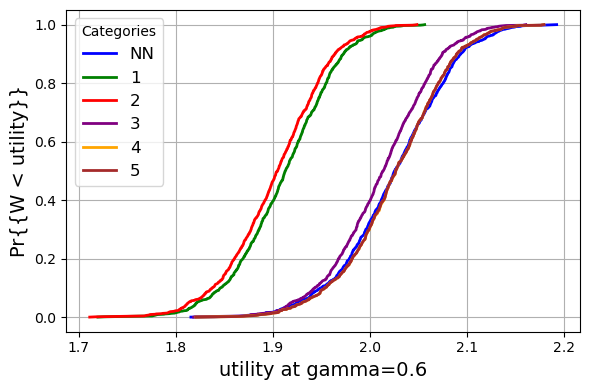

,Mean,Median,Std Dev,Pr(W_NN < W_i)
Strategy,,,,
NN,2.024542,2.025266,0.056932,/
1,1.911370,1.912678,0.050546,0.0
2,1.902793,1.904721,0.050547,0.0
3,2.011427,2.013372,0.052383,0.10274
4,2.025038,2.026429,0.053748,0.51272
5,2.024983,2.026429,0.053784,0.507828


In [196]:
W_all = { 'NN': [], '1': [], '2': [], '3': [], '4': [], '5': [] }

print('probability of losing out to any strategy or the terminal capital less than initial capital = ', total_loss_count_vali/numSim)

for path in results_vali:
    for i, key in enumerate(W_all.keys()):
        if key == 'NN':
            strategy = 0
        else:
            strategy = int(key)

        C_T = results_vali[path][strategy][4][T]
        u0_ = results_vali[path][strategy][0]
        C_ = results_vali[path][strategy][4]

        total_utility = U(C_T, gamma) * v**T + sum([ v**t * U(u0_[t]*C_[t], gamma) for t in range(T)])
        W_all[key].append(total_utility)

def compute_ecdf(data):
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ecdf

plt.figure(figsize=(6, 4))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for i, (label, color) in enumerate(zip(W_all.keys(), colors)):
    sorted_vals, ecdf_vals = compute_ecdf(W_all[label])
    plt.plot(sorted_vals, ecdf_vals, label=label, color=color, linewidth=2)

plt.xlabel(f'utility at gamma={gamma}', fontsize=14)
plt.ylabel('Pr{{W < utility}}', fontsize=14)
plt.legend(title='Categories', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

W_nn = W_all['NN']

# summary_stats_1 = {
#     "Strategy": [],
#     "CE Utility": [],
#     "Expected Shortfall (5%)": []
#     }
# for key in W_all:
#     ceu = certainty_equivalent(W_all[key], gamma)
#     es = expected_shortfall(C_T_all[key], alpha=0.05)
#     summary_stats["Strategy"].append(key)
#     summary_stats["CE Utility"].append(ceu)
#     summary_stats["Expected Shortfall (5%)"].append(es)
# df_summary1 = pd.DataFrame(summary_stats_1)
# display(df_summary1)

summary_stats_2 = {
    "Strategy": list(W_all.keys()),
    "Mean": [np.mean(W_all[k]) for k in W_all],
    "Median": [np.median(W_all[k]) for k in W_all],
    "Std Dev": [np.std(W_all[k]) for k in W_all],
    "Pr(W_NN < W_i)": ['/'] + [np.mean(np.array(W_nn) < np.array(W_all[key])) for key in list(W_all.keys())[1:]]
}
df_summary2 = pd.DataFrame(summary_stats_2)
df_summary2 = df_summary2.set_index("Strategy")
display(df_summary2)


In [197]:
some_paths = [random.randint(1, numTest-1) for _ in range(5)]

for some in range(1,len(some_paths)):
    print('')
    print(f'for tested path no.{some}')
    for t in range(1,T+1):
        print(
             f'u_t={t}: ', round(results_vali[some_paths[some]][0][0][t],4),round(results_vali[some_paths[some]][0][1][t],2), round(results_vali[some_paths[some]][0][2][t],2), round(results_vali[some_paths[some]][0][3][t],2),
             f'L_t={t} : ', round(np.exp((ln_L_0) + sum((d_ln_L_vali[some_paths[some], j]) for j in range(1, t))),2),
             f'C_t={t} : ', round(results_vali[some_paths[some]][0][4][t],2),
             round(U(results_vali[some_paths[some]][0][4][t],gamma),2)
            )



for tested path no.1
u_t=1:  0.006 0.05 0.85 0.1 L_t=1 :  0.21 C_t=1 :  1.05 1.71
u_t=2:  0.006 0.05 0.85 0.1 L_t=2 :  0.21 C_t=2 :  1.11 1.77
u_t=3:  1.0 1.0 1.0 1.0 L_t=3 :  0.22 C_t=3 :  1.11 1.78

for tested path no.2
u_t=1:  0.006 0.0 0.85 0.15 L_t=1 :  0.21 C_t=1 :  1.09 1.76
u_t=2:  0.006 0.0 0.85 0.15 L_t=2 :  0.21 C_t=2 :  1.18 1.84
u_t=3:  1.0 1.0 1.0 1.0 L_t=3 :  0.21 C_t=3 :  1.28 1.93

for tested path no.3
u_t=1:  0.006 0.0 0.85 0.15 L_t=1 :  0.21 C_t=1 :  1.08 1.75
u_t=2:  0.006 0.05 0.55 0.4 L_t=2 :  0.2 C_t=2 :  1.13 1.79
u_t=3:  1.0 1.0 1.0 1.0 L_t=3 :  0.19 C_t=3 :  1.16 1.82

for tested path no.4
u_t=1:  0.006 0.05 0.85 0.1 L_t=1 :  0.21 C_t=1 :  1.05 1.72
u_t=2:  0.006 0.05 0.55 0.4 L_t=2 :  0.21 C_t=2 :  1.15 1.81
u_t=3:  1.0 1.0 1.0 1.0 L_t=3 :  0.2 C_t=3 :  1.22 1.87


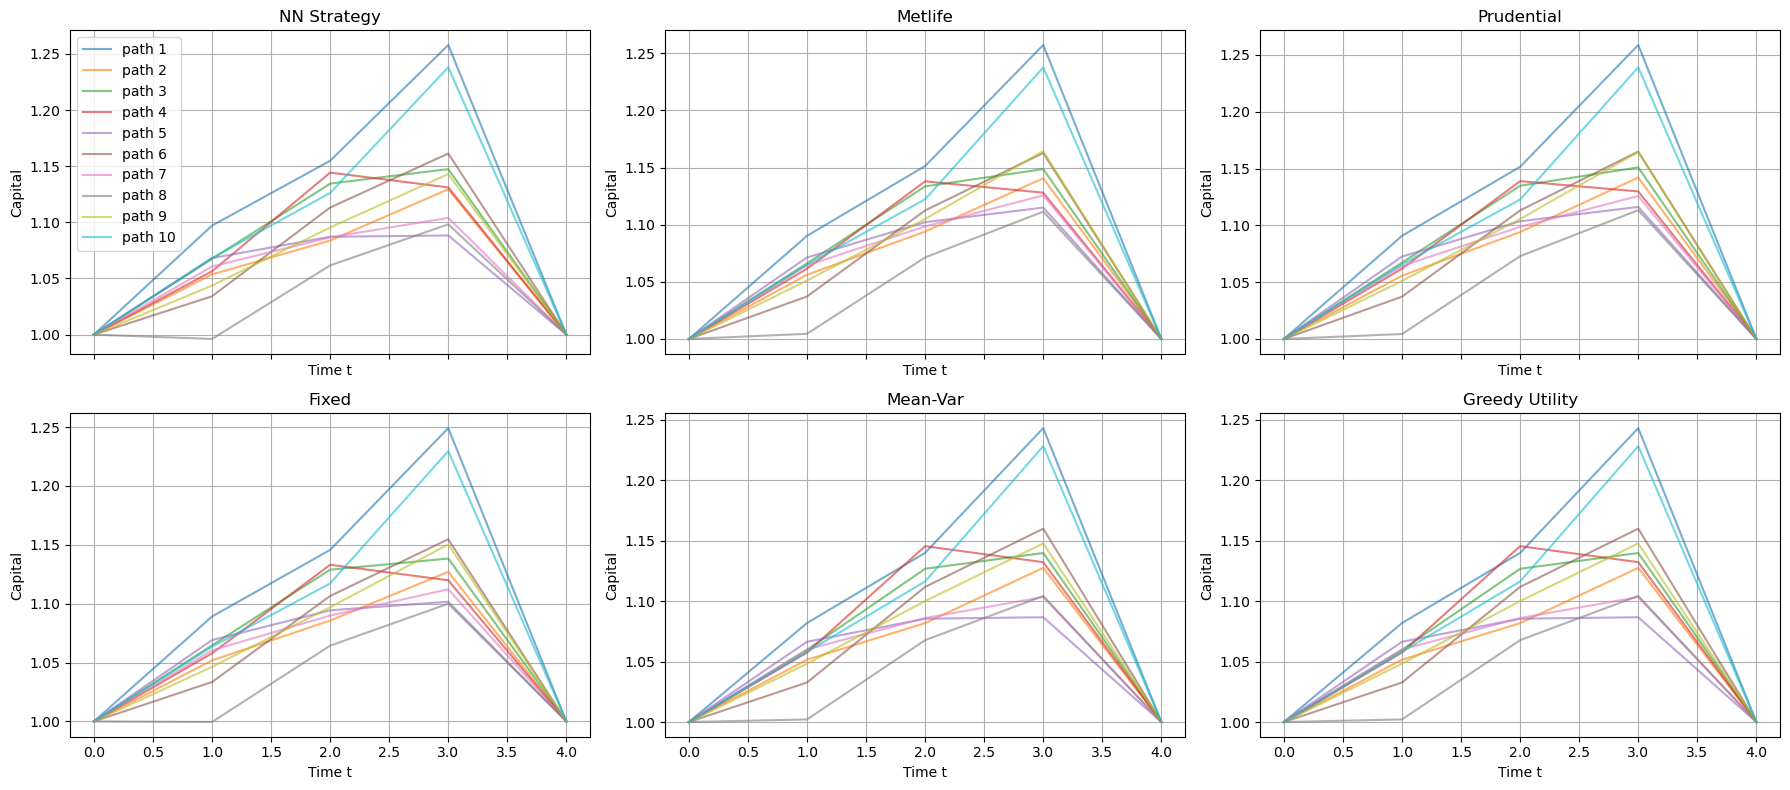

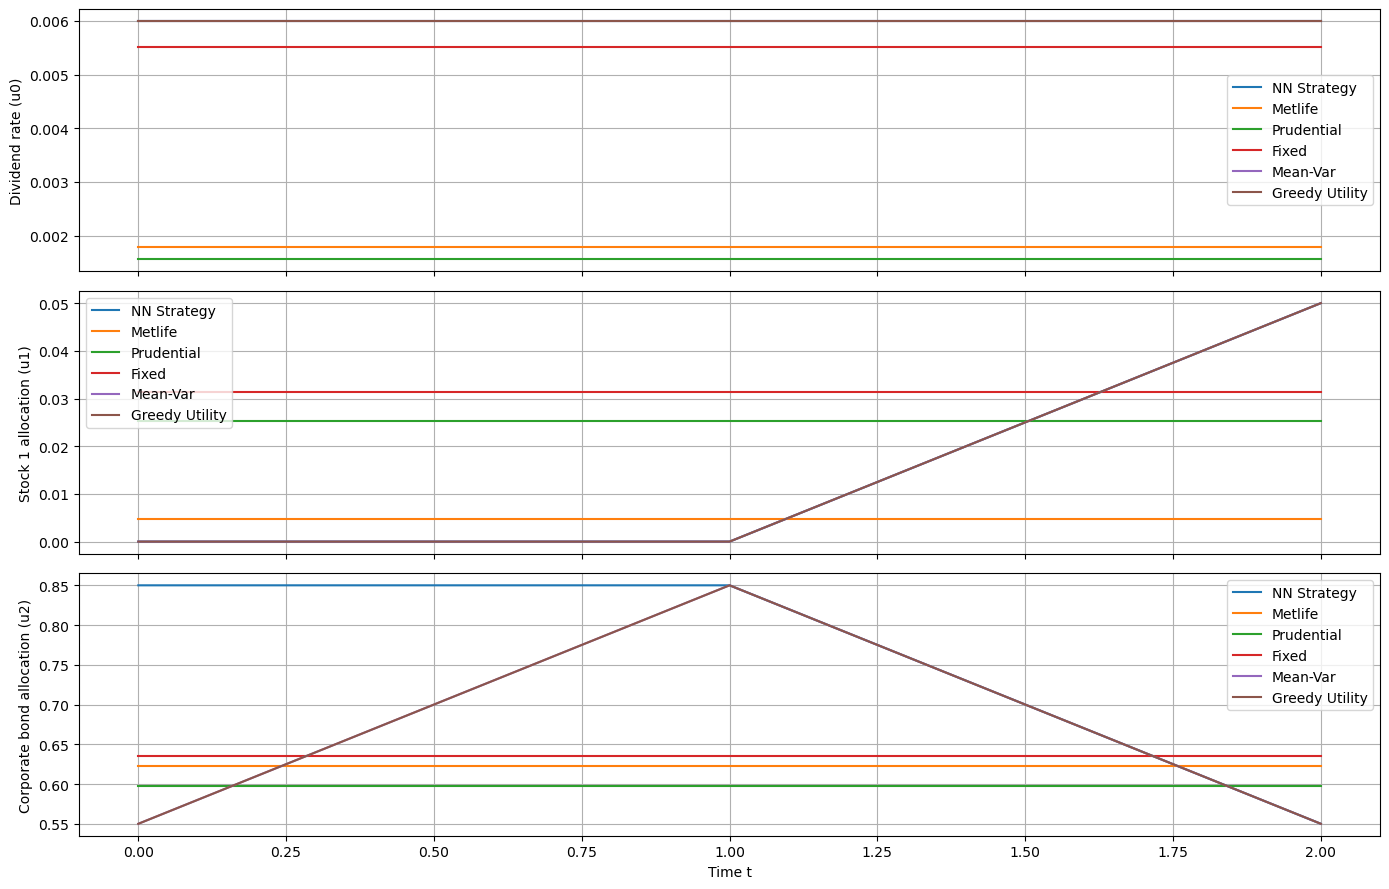

In [207]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from typing import Dict

# Load results_vali from file if available (user must have run the previous block already)
# Simulate mock structure if not (to illustrate plotting logic)

def plot_capital_paths(results_vali: Dict[int, np.ndarray], num_paths: int = 10):
    """
    Plot the capital paths for each strategy across a few paths.
    """
    strategies = {
        0: "NN Strategy",
        1: "Metlife",
        2: "Prudential",
        3: "Fixed",
        4: "Mean-Var",
        5: "Greedy Utility"
    }
    
    T = results_vali[1].shape[2] - 1  # T+1 because t+1 capital is stored
    time_grid = np.arange(T+1)
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=False)
    axs = axs.flatten()
    
    for strat in range(6):
        ax = axs[strat]
        for path in list(results_vali.keys())[:num_paths]:
            capital_path = results_vali[path][strat, 4, :]
            ax.plot(time_grid, capital_path, label=f"path {path}", alpha=0.6)
        ax.set_title(strategies[strat])
        ax.set_xlabel("Time t")
        ax.set_ylabel("Capital")
        ax.grid(True)
    
    axs[0].legend()
    plt.tight_layout()
    return fig


def plot_control_trajectories(results_vali: Dict[int, np.ndarray], path: int = 1):
    """
    For a given path, plot the dividend and investment controls of each strategy over time.
    """
    strategies = {
        0: "NN Strategy",
        1: "Metlife",
        2: "Prudential",
        3: "Fixed",
        4: "Mean-Var",
        5: "Greedy Utility"
    }
    
    T = results_vali[path].shape[2] - 2  # T (not T+1) time points for controls
    time_grid = np.arange(T)
    
    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    
    for strat in range(6):
        dividend = results_vali[path][strat, 0, :T]
        stock1 = results_vali[path][strat, 1, :T]
        cbond = results_vali[path][strat, 2, :T]
        
        axs[0].plot(time_grid, dividend, label=strategies[strat])
        axs[1].plot(time_grid, stock1, label=strategies[strat])
        axs[2].plot(time_grid, cbond, label=strategies[strat])
    
    axs[0].set_ylabel("Dividend rate (u0)")
    axs[1].set_ylabel("Stock 1 allocation (u1)")
    axs[2].set_ylabel("Corporate bond allocation (u2)")
    axs[2].set_xlabel("Time t")
    
    for ax in axs:
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    return fig

# Execute plotting
fig_capital = plot_capital_paths(results_vali)
fig_controls = plot_control_trajectories(results_vali, path=1)
